In [2]:
from intonatang import intonatang as tang
from intonatang import paper_figures as figs
from intonatang import timit
from intonatang import pitch_trf as ptrf
from intonatang import erps

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_context("talk")

import warnings
warnings.filterwarnings('ignore')

## Process neural activity

From the high-gamma time series extracted from each channel during preprocessing and task information (sentence onset times and order of tokens played), we produce `Y_mat` matrices which are ndarrays with the shape `n_chans` x `n_timepoints` x `n_trials`, as well as lists of stimulus conditions. These are generated and saved by `tang.save_Y_mat_sns_sts_sps_for_subject_number`, which takes a `subject_number` as its only parameter.

In [3]:
tang.save_Y_mat_sns_sts_sps_for_subject_number(113)

To load the processed neural (and task) data, we use `tang.load_Y_mat_sns_sts_sps_for_subject_number`. 

1. `Y_mat` contains high-gamma with a rolling windowed mean applied, such that each time point is the average of a 60ms window moving in 30ms steps. You can get the centers of the windows with `tang.get_centers()` (with default parameters).
2. `sns` is a list of sentence conditions. 
    * 1 -> "Humans value genuine behavior"
    * 2 -> "Movies demand minimal energy"
    * 3 -> "Reindeer are a visual animal"
    * 4 -> "Lawyers give a relevant opinion"
3. `sts` is a list of intonation conditions (sentence types)
    * 1 -> Neutral
    * 2 -> Question
    * 3 -> Emphasis 1
    * 4 -> Emphasis 3
4. `sps` is a list of speaker conditions
    * 1 -> Male (low formant, low pitch)
    * 2 -> Female 1 (high formant, high pitch)
    * 3 -> Female 2 (low formant, high pitch)
5. `Y_mat_plotter` contains the full 100Hz high-gamma time-series. The 300 timepoints in axis=1 are from -250ms to +2750ms relative to sentence onset

In [4]:
Y_mat, sns, sts, sps, Y_mat_plotter = tang.load_Y_mat_sns_sts_sps_for_subject_number(113)

## Plotter: see average neural activity traces

To see the average neural responses to different tokens, you can create a plotter. With the plotter, you can plot average neural responses for every channel between [0, 256). The first parameter of a plotter's plot method is the channel number. axes_by and traces_by can be either "sentence_number"

In [5]:
plotter = tang.Plotter(Y_mat_plotter, sns, sts, sps)

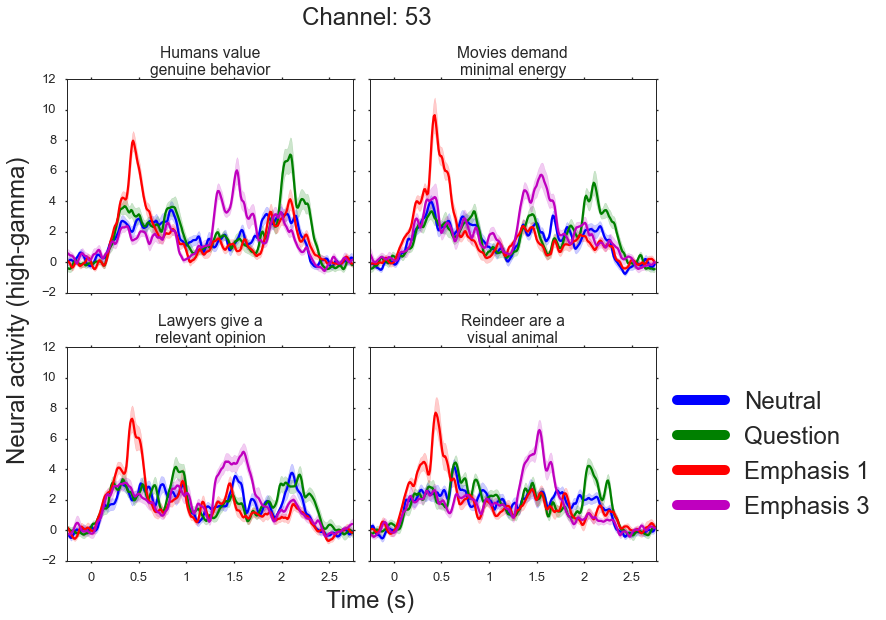

In [6]:
fig = plotter.plot(53, axes_by="sentence_number", traces_by="sentence_type")

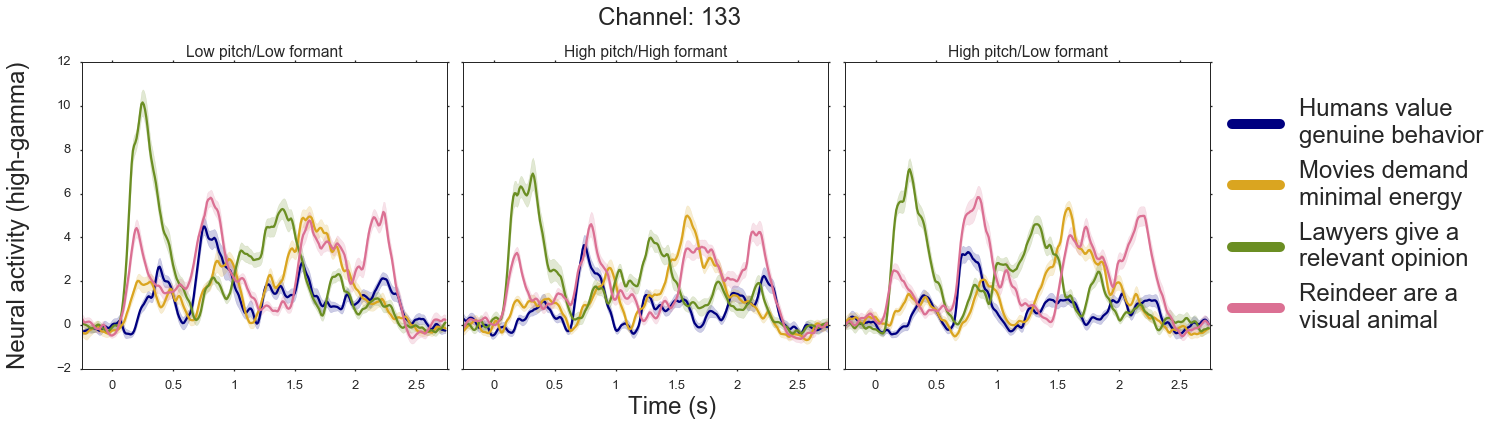

In [7]:
fig = plotter.plot(133, axes_by="speaker", traces_by="sentence_number")

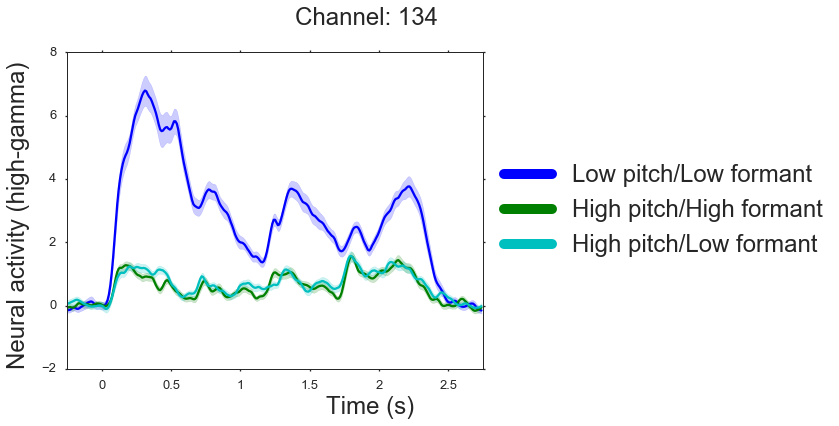

In [8]:
fig = plotter.plot(134, axes_by="none", traces_by="speaker")

## Single-electrode categorical encoding analysis

In [8]:
r2_varpart, p_varpart, f_varpart = tang.single_electrode_encoding_varpart(Y_mat, sns, sts, sps)
f_values, f_p_values, betas, betas_p_values, total_r2 = tang.single_electrode_encoding_all_weights(Y_mat, sns, sts, sps)

In [9]:
tang.save_encoding_results(113, r2_varpart, p_varpart, f_varpart)
tang.save_encoding_results_all_weights(113, f_values, f_p_values, betas, betas_p_values, total_r2)

In [9]:
r2_varpart, p_varpart, f_varpart = tang.load_encoding_results(113)
f_values, f_p_values, betas, betas_p_values, total_r2 = tang.load_encoding_results_all_weights(113)

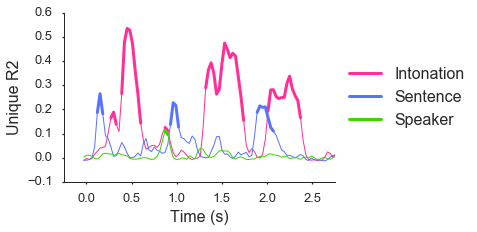

In [10]:
centers = tang.get_centers()
fig = tang.plot_r2_single_electrode_encoding_single_subsets(centers, r2_varpart, p_varpart, 53)

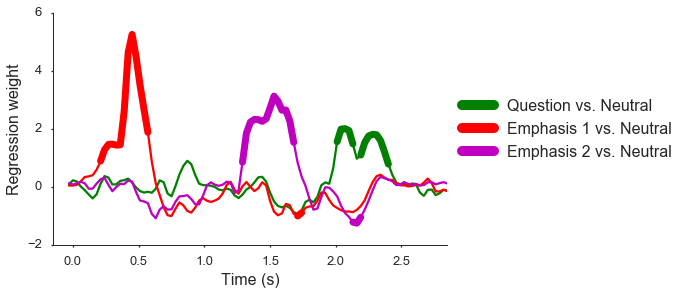

In [11]:
fig = tang.plot_betas_intonation(centers, betas, betas_p_values, 53)

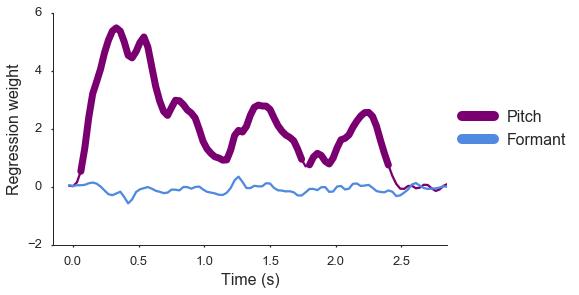

In [12]:
fig = tang.plot_betas_speakers(centers, betas, betas_p_values, 134)

In [13]:
sig_elecs = tang.get_sig_elecs_from_full_model(113)
not_sig_times = f_p_values > 0.05/(256*101)

for chan in range(256):
    r2_varpart[chan, not_sig_times[chan], :] = np.NaN

r_mean = np.nanmean(r2_varpart, axis=1)
r_max = np.nanmax(r2_varpart, axis=1)
cat = np.argmax(r_max, axis=1)
cat[~sig_elecs] = -1

df = pd.DataFrame(r_mean, columns=['sn', 'st', 'sp', 'sn st' ,'sn sp' ,'st sp', 'sn st sp'])

df[df<0] = 0
df['total_r2'] = df.sum(axis=1)
for col in ['sn', 'st', 'sp', 'sn st' ,'sn sp' ,'st sp', 'sn st sp']:
    df[col] = df[col]/df['total_r2']

df['cat'] = cat

df = df[['st', 'sn', 'sp', 'sn st', 'st sp', 'sn sp', 'sn st sp', 'cat']]

In [14]:
df_sig = df.iloc[sig_elecs]

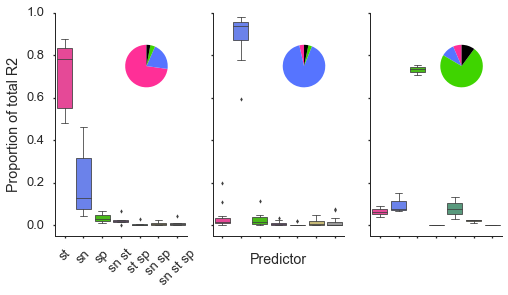

In [15]:
seaborn.set_context("talk")
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
_ = figs.add_encoding_boxplots_to_axs(axs.flatten(), df_sig)

## Anatomical location

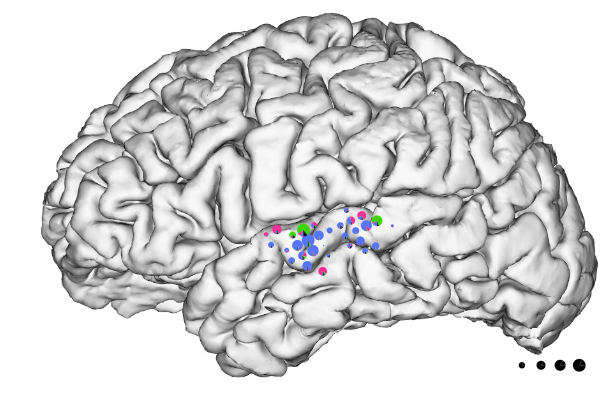

In [16]:
fig, ax, stat_sums = tang.plot_pie_chart_for_subject_number(113, on_brain=True)

## Pitch temporal receptive field analysis

The pitch temporal receptive field (ptrf) analysis, or pitch encoding analysis, uses data collected as participants listened to a separate speech corpus containing sentences spoken hundreds of speakers.

To get started, we first generate the processed timit data, which creates data structures containing absolute and relative pitch descriptions for all timit sentences. We'll also create some shuffled data where pitch contours between different timit sentences are shuffled to be used in a later permutation test.

In [17]:
timit.generate_processed_timit_data()

In [23]:
timit_pitch = timit.get_timit_pitch()
for i in range(25):
    ptrf.randomize_timit_pitch_contours(timit_pitch, save_as=i)

The ptrf analysis consists of the ptrf analysis pipeline and the permutation test. The permutation test is used to determined whether the unique variance explained by either absolute or relative pitch is significant. The following two lines of code take a few hours to run.

In [25]:
ptrf.run_ptrf_analysis_permutation_test(113)
ptrf.run_ptrf_analysis_pipeline_for_subject_number(113)

In [17]:
r_both, r_abs, r_rel, r2_abs, r2_rel, wts_all, wts_abs, wts_rel = ptrf.load_cv_model_fold(113)
r2_both_perms, r2_abs_perms, r2_rel_perms = ptrf.load_cv_shuffle_fold(113)


In [18]:
wts = np.mean(wts_all, axis=2) # take the average over the 25 cross-validation folds

In [19]:
r2_both = np.mean(r_both**2, axis=1)

In [20]:
seaborn.set_context("talk")

0.253453786063
-0.00605371067461
0.0214470015394


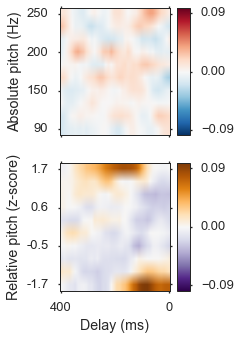

In [21]:
fig = ptrf.plot_trf(wts, 53)
print(r2_both[53])
print(r2_abs[0, 53])
print(r2_rel[0, 53])

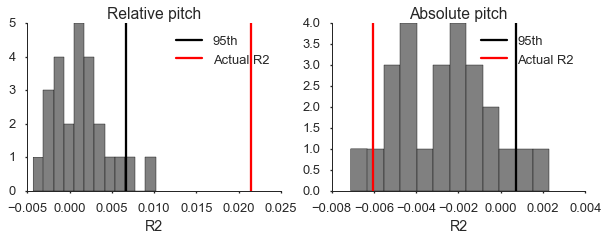

In [22]:
chan = 53
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].hist(r2_rel_perms[chan], bins=12, color='gray')
h2 = axs[0].axvline(r2_rel[0, chan], 0, 1, color='r')
h1 = axs[0].axvline(np.percentile(r2_rel_perms[chan], [95])[0], 0, 1, color='k')
axs[0].set(title="Relative pitch", xlabel="R2")
axs[0].legend([h1, h2], ['95th', 'Actual R2'])

axs[1].hist(r2_abs_perms[chan], bins=12, color='gray')
h1 = axs[1].axvline(np.percentile(r2_abs_perms[chan], [95])[0], 0, 1, color='k')
h2 = axs[1].axvline(r2_abs[0, chan], 0, 1, color='r')
axs[1].set(title="Absolute pitch", xlabel="R2")
axs[1].legend([h1, h2], ['95th', 'Actual R2'])
seaborn.despine()

0.333473164092
0.24219178896
0.0122541421507


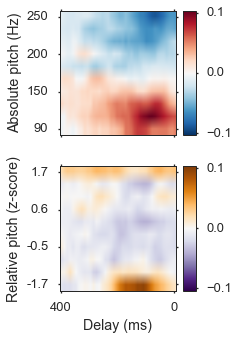

In [23]:
fig = ptrf.plot_trf(wts, 134)
print(r2_both[134])
print(r2_abs[0, 134])
print(r2_rel[0, 134])

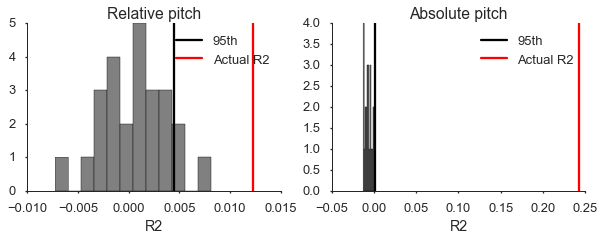

In [24]:
chan = 134
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].hist(r2_rel_perms[chan], bins=12, color='gray')
h2 = axs[0].axvline(r2_rel[0, chan], 0, 1, color='r')
h1 = axs[0].axvline(np.percentile(r2_rel_perms[chan], [95])[0], 0, 1, color='k')
axs[0].set(title="Relative pitch", xlabel="R2")
axs[0].legend([h1, h2], ['95th', 'Actual R2'])

axs[1].hist(r2_abs_perms[chan], bins=12, color='gray')
h1 = axs[1].axvline(np.percentile(r2_abs_perms[chan], [95])[0], 0, 1, color='k')
h2 = axs[1].axvline(r2_abs[0, chan], 0, 1, color='r')
axs[1].set(title="Absolute pitch", xlabel="R2")
axs[1].legend([h1, h2], ['95th', 'Actual R2'])
seaborn.despine()

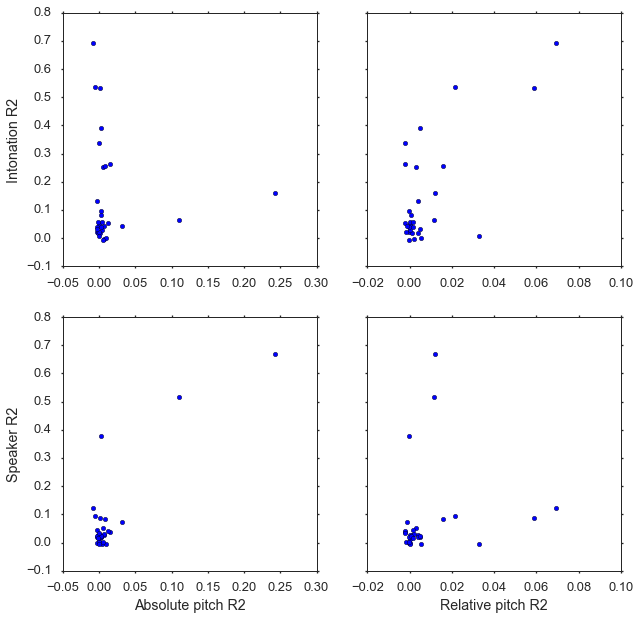

In [25]:
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharey=True)
axs[0, 0].scatter(r2_abs, r_max[:, 1])
axs[0, 1].scatter(r2_rel, r_max[:, 1])
axs[1, 0].scatter(r2_abs, r_max[:, 2])
axs[1, 1].scatter(r2_rel, r_max[:, 2])
axs[0, 0].set_ylabel("Intonation R2")
axs[1, 0].set(ylabel="Speaker R2", xlabel="Absolute pitch R2")
axs[1, 1].set(xlabel="Relative pitch R2")

In [26]:
chan = 53
all_preds1, all_preds_ste1, abs_pred1, abs_pred_ste1, rel_pred1, rel_pred_ste1, all_preds2, all_preds_ste2, abs_pred2, abs_pred_ste2, rel_pred2, rel_pred_ste2 = ptrf.predict_response_to_intonation_stims(113, chan)

Y_mat, sns, sts, sps, Y_mat_plotter = tang.load_Y_mat_sns_sts_sps_for_subject_number(113, zscore_to_silence=False)
male = [Y_mat_plotter[:, :, np.logical_and(sps==1,sts==i)] for i in range(1,5)]
female = [Y_mat_plotter[:, :, np.logical_and(np.logical_or(sps==2,sps==3),sts==i)] for i in range(1,5)]
actual_means_stes = [erps.get_mean_and_ste(sp1_one)[0:2] for sp1_one in male + female]
actual_means1 = [a[0] for a in actual_means_stes]
actual_stes1 = [a[1] for a in actual_means_stes]
speakers = [Y_mat_plotter[:, :, sps==1], Y_mat_plotter[:, :, np.logical_or(sps==2, sps==3)]]
actual_means_stes = [erps.get_mean_and_ste(sp1_one)[0:2] for sp1_one in speakers]
actual_means2 = [a[0] for a in actual_means_stes]
actual_stes2 = [a[1] for a in actual_means_stes]

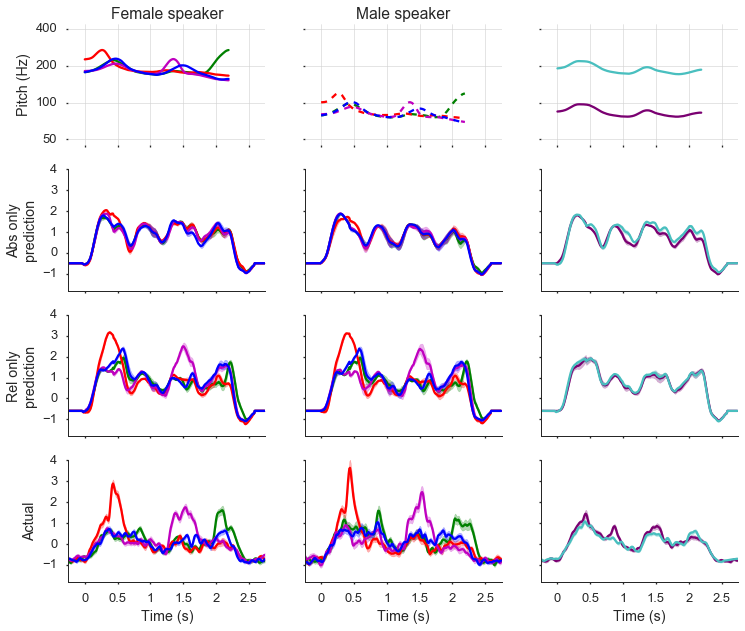

In [28]:
fig, axs = plt.subplots(4, 3, figsize=(12, 10))

figs.plot_pitch(axs[0][0], axs[0][1], axs[0][2])
xvals = np.arange(0,300)/100 - 0.25

# Predicted and actual high-gamma by intonation contour for two sexes shown separately
figs.plot_intonation(xvals, abs_pred1[0:4], abs_pred_ste1[0:4], axs[1][1], chan)
figs.plot_intonation(xvals, abs_pred1[4:8], abs_pred_ste1[4:8], axs[1][0], chan)
figs.plot_intonation(xvals, rel_pred1[0:4], rel_pred_ste1[0:4], axs[2][1], chan)
figs.plot_intonation(xvals, rel_pred1[4:8], rel_pred_ste1[4:8], axs[2][0], chan)
figs.plot_intonation(xvals, actual_means1[0:4], actual_stes1[0:4], axs[3][1], chan)
figs.plot_intonation(xvals, actual_means1[4:8], actual_stes1[4:8], axs[3][0], chan)

# Predicted and actual high-gamnma averaged over sex of speaker
figs.plot_speaker(xvals, abs_pred2[0:3], abs_pred_ste2[0:3], axs[1][2], chan)
figs.plot_speaker(xvals, rel_pred2[0:3], rel_pred_ste2[0:3], axs[2][2], chan)
figs.plot_speaker(xvals, actual_means2[0:3], actual_stes2[0:3], axs[3][2], chan)

axs[0][0].set(title="Female speaker")
axs[0][1].set(title="Male speaker")
axs[1][0].set(ylabel="Abs only\nprediction")
axs[2][0].set(ylabel="Rel only\nprediction")
axs[3][0].set(ylabel="Actual")

for ax in axs[1:, :].flatten():
    ax.set(xlim=(-0.25, 2.75), xticks=[0, 0.5, 1, 1.5, 2, 2.5], xticklabels=[], ylim=(-1.8,4), yticks=[-1,0,1,2,3,4])
for ax in axs[:, 1:].flatten():
    ax.set(yticklabels=[])
for ax in axs[3,:]:
    ax.set(xticklabels=['0', '0.5', '1', '1.5', '2', '2.5'], xlabel="Time (s)")
    
for ax in axs.flatten():
    seaborn.despine(ax=ax)